# Détection d’objets en mouvement avec un Spiking Neural Network sur des données de caméra neuromorphique

J'ai tenté d'améliorer la perfommance du modèle avec les ajouts suivants.
Ajout de BatchNorm et de Dropout pour rendre l’apprentissage plus stable et réduire risque de surapprentissage. Et ajout d'une troisième couche convolutionnelle pour renforcer la capacité du réseau à extraire des motifs spatio-temporels. On part également sur 5 epochs.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.clock_driven import neuron, functional
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [ ]:
data_dir = './Datasets/download/DvsGesture/'

train_set = DVS128Gesture(
    root=data_dir,
    train=True,
    data_type='frame',
    frames_number=10,
    split_by='number'
)

test_set = DVS128Gesture(
    root=data_dir,
    train=False,
    data_type='frame',
    frames_number=10,
    split_by='number'
)

train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=2)

print(f" Nombre d’échantillons d’entraînement : {len(train_set)}")
print(f" Nombre d’échantillons de test : {len(test_set)}")

The directory [./Datasets/download/DvsGesture/frames_number_10_split_by_number] already exists.
The directory [./Datasets/download/DvsGesture/frames_number_10_split_by_number] already exists.
 Nombre d’échantillons d’entraînement : 1176
 Nombre d’échantillons de test : 288


In [ ]:
class EnhancedSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.lif1 = neuron.LIFNode()
        self.pool1 = nn.AvgPool2d(2)
        self.drop1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.lif2 = neuron.LIFNode()
        self.pool2 = nn.AvgPool2d(2)
        self.drop2 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.lif3 = neuron.LIFNode()
        self.pool3 = nn.AvgPool2d(2)
        self.drop3 = nn.Dropout(0.4)

        with torch.no_grad():
            dummy = torch.zeros(1, 2, 128, 128)
            out = self.pool1(self.lif1(self.bn1(self.conv1(dummy))))
            out = self.pool2(self.lif2(self.bn2(self.conv2(out))))
            out = self.pool3(self.lif3(self.bn3(self.conv3(out))))
            flatten_dim = out.numel()
        print(f"Taille d’entrée du FC : {flatten_dim}")
        self.fc = nn.Linear(flatten_dim, 11)

    def forward(self, x):
        x = x.float()
        T = x.shape[0]
        N = x.shape[1]

        out_spikes_counter = torch.zeros(N, 11, device=x.device)
        functional.reset_net(self)

        for t in range(T):
            out = self.conv1(x[t])
            out = self.bn1(out)
            out = self.lif1(out)
            out = self.pool1(out)
            out = self.drop1(out)

            out = self.conv2(out)
            out = self.bn2(out)
            out = self.lif2(out)
            out = self.pool2(out)
            out = self.drop2(out)

            out = self.conv3(out)
            out = self.bn3(out)
            out = self.lif3(out)
            out = self.pool3(out)
            out = self.drop3(out)

            out = out.flatten(1)
            out = self.fc(out)
            out_spikes_counter += out

        return out_spikes_counter / T


In [ ]:
# Entraînement
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EnhancedSNN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

epochs = 5
loss_history = []

print("🚀 Début de l'entraînement...\n")
for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Époch {epoch+1}/{epochs}")

    for frame, label in loop:
        frame = frame.to(device)
        label = label.to(device)
        frame = frame.permute(1, 0, 2, 3, 4)

        optimizer.zero_grad()
        out = model(frame)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f" Perte moyenne epoch {epoch+1}: {avg_loss:.4f}")

print("\n Entraînement terminé !")

Taille d’entrée du FC : 16384
🚀 Début de l'entraînement...



Époch 1/5: 100%|██████████| 147/147 [00:36<00:00,  4.07it/s, loss=0.934]


 Perte moyenne epoch 1: 1.1633


Époch 2/5: 100%|██████████| 147/147 [00:36<00:00,  4.04it/s, loss=0.265]


 Perte moyenne epoch 2: 0.6683


Époch 3/5: 100%|██████████| 147/147 [00:37<00:00,  3.93it/s, loss=0.45] 


 Perte moyenne epoch 3: 0.4778


Époch 4/5: 100%|██████████| 147/147 [00:36<00:00,  3.98it/s, loss=0.454] 


 Perte moyenne epoch 4: 0.3378


Époch 5/5: 100%|██████████| 147/147 [00:36<00:00,  4.04it/s, loss=0.234] 

 Perte moyenne epoch 5: 0.3007

 Entraînement terminé !


In [ ]:
# Évaluation

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for frame, label in test_loader:
        frame = frame.to(device)
        label = label.to(device)
        frame = frame.permute(1, 0, 2, 3, 4)
        out = model(frame)
        preds = torch.argmax(out, dim=1)
        correct += (preds == label).sum().item()
        total += label.size(0)

acc = 100 * correct / total
print(f"\n Précision finale sur le jeu de test : {acc:.2f}%")



 Précision finale sur le jeu de test : 75.35%


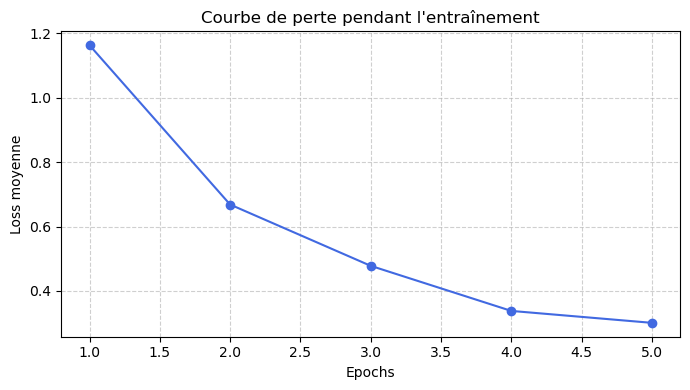

In [ ]:
# Visualisation

plt.figure(figsize=(7, 4))
plt.plot(range(1, epochs + 1), loss_history, marker='o', color='royalblue')
plt.title("Courbe de perte pendant l'entraînement")
plt.xlabel("Epochs")
plt.ylabel("Loss moyenne")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()




On voit une amélioration de la précision de 68.06%(premier modèle) à 75.35%(modèle amélioré). Les ajouts ont donc vraiment aidées à l'amélioration du modèle.